In [1]:
from food.tools import *
from food.paths import *
from food.psql import *
import requests
from food.qdrant import *
import torch
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-08)
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

import shapely
import shapely.geometry
from PIL import ImageFont, ImageDraw, Image

dev


In [2]:
def read_image_from_url(url=None,path=None):
    if url: response = requests.get(url, stream=True)
    if path: pass
    return Image.open(response.raw)

In [3]:
def crop_image_to_square(img):
    height = img.size[1]//2*2
    left  = int((img.size[0]-height)/2)
    right =      img.size[0]-left
    return img.crop((left,0,right,height))

In [4]:
def box_area(box):
    return (box[2]-box[0])*(box[3]-box[1])

In [28]:
foods = read_sql('foods')

# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')
foods = foods.dropna()

In [29]:
series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [30]:
food_clips = series2tensor(foods['clip'])

In [31]:
def search_clip(url,head = 1):
    image_clip = requests.post(f'http://127.0.0.1:8182/image2vector/?url={url}').json()
    image_clip = torch.tensor(image_clip)
    df = foods.copy()
    df['score'] = cos(food_clips,image_clip)
    df = df.sort_values('score',ascending=False)[:head]

    return image_clip,df.reset_index()

In [32]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [15.00, 15.0]
plt.rcParams["figure.autolayout"] = True

In [44]:
url = 'https://image.shutterstock.com/z/stock-photo-chicken-fillet-with-salad-healthy-food-keto-diet-diet-lunch-concept-top-view-on-white-1721943142.jpg'
image = get_image_from_url(url)
image = crop_image_to_square(image)
total_size = image.size[0]*image.size[1]

In [45]:
thershold = 0.0003
params = {'url':url,'thershold':thershold}
boxes,mask = requests.post('http://127.0.0.1:8185/get_boxes/?',params = params).json()
mask = np.array(mask)

In [46]:
df = pd.DataFrame()
df['area'] = [box_area(box) for box in boxes]
df['boxes'] = boxes
df = df.reset_index()

In [47]:
photo_id = url.split('/')[-1]
urls = []
for d in df[['index','boxes']].to_dict('records'):
    id,box = d.values()
    urls.append(f'https://dima.grankin.eu/fragment_reference_images/{photo_id}_{id}.jpg')
clip_df = pd.DataFrame()
for u in urls:
    clip_df = clip_df.append(search_clip(u,head = 1)[1])
clip_df = clip_df.reset_index(drop = True)[['description','category','energy','protein','carb','fat','score']]

/tmp/ipykernel_561599/1755054275.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_561599/1755054275.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_561599/1755054275.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_561599/1755054275.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(search_clip(u,head = 1)[1])
/tmp/ipykernel_561599/1755054275.py:8: FutureWarning: The frame.append method is deprecated 

In [48]:
df = clip_df.join(df)
df = df[df['score']>0.24]
df = df.sort_values('area',ascending = False)
df = df.reset_index(drop=True).reset_index()
df = df.rename(columns = {'level_0':'box_area_rank'})
# df = df.sort_values('box_area_rank',ascending = False)
df['boxes'] = df['boxes'].apply(lambda b:[int(bb) for bb in b])

In [49]:
arrays= []
for row in df[['box_area_rank','energy','boxes']].iterrows():
    
    row = row[1]
    b = row['boxes']
    rank   = np.zeros(image.size)
    rank  [b[1]:b[3],b[0]:b[2]] = row['box_area_rank']
    
    energy = np.zeros(image.size)
    energy  [b[1]:b[3],b[0]:b[2]]= row['energy']
    
    row_array = np.stack([rank,energy])
    arrays.append(row_array)
arrays = np.stack(arrays)
arrays = arrays*mask.T

In [50]:
classes =  arrays[:,0,:,:].max(0)
df_count_classes = df[['box_area_rank','description']].set_index('box_area_rank').reindex(classes.reshape(classes.shape[0]*classes.shape[0]))
df_count_classes = df_count_classes.dropna().reset_index().groupby('description').count().sort_values('box_area_rank',ascending = False).head(20)
df_count_classes['%'] = (df_count_classes['box_area_rank']/df_count_classes['box_area_rank'].sum()).round(2)
r = df_count_classes[['%']].join(df.drop_duplicates('description').set_index('description')[['category','energy','protein','carb','fat']])
r[r['%']>0.005]

,%,category,energy,protein,carb,fat
description,,,,,,
"Chicken or turkey garden salad with bacon and cheese, chicken and/or turkey, bacon, cheese, lettuce and/or greens, tomato and/or carrots, other vegetables, no dressing",0.64,Poultry mixed dishes,104.0,11.08,2.78,5.61
"Chicken breast, baked, broiled, or roasted, skin not eaten, from raw",0.08,"Chicken, whole pieces",161.0,30.22,0.00,3.52
"Lettuce, arugula, raw",0.07,Lettuce and lettuce salads,25.0,2.58,3.65,0.66
"Chicken or turkey garden salad with cheese, chicken and/or turkey, cheese, lettuce and/or greens, tomato and/or carrots, other vegetables, no dressing",0.04,Poultry mixed dishes,91.0,10.40,2.80,4.52
"Chicken breast, baked, broiled, or roasted with marinade, skin not eaten, from raw",0.03,"Chicken, whole pieces",174.0,29.13,0.31,5.38
"Lettuce, salad with egg, tomato, and/or carrots, with or without other vegetables, no dressing",0.03,Lettuce and lettuce salads,48.0,3.54,3.64,2.30
"Chicken breast, baked, broiled, or roasted, skin eaten, from raw",0.02,"Chicken, whole pieces",192.0,26.25,0.00,8.80
"Chicken breast, baked or broiled, skin not eaten, from pre-cooked",0.02,"Chicken, whole pieces",144.0,28.04,0.00,3.57
"Chicken breast, baked or broiled, skin not eaten, from fast food / restaurant",0.02,"Chicken, whole pieces",175.0,29.56,0.00,5.44


In [51]:
colories_tensor = np.where((arrays[:,0,:,:] == arrays[:,0,:,:].max(0)),arrays[:,1,:,:],0).max(0)
colories_tensor[colories_tensor!=0].mean()

137.7330199163504

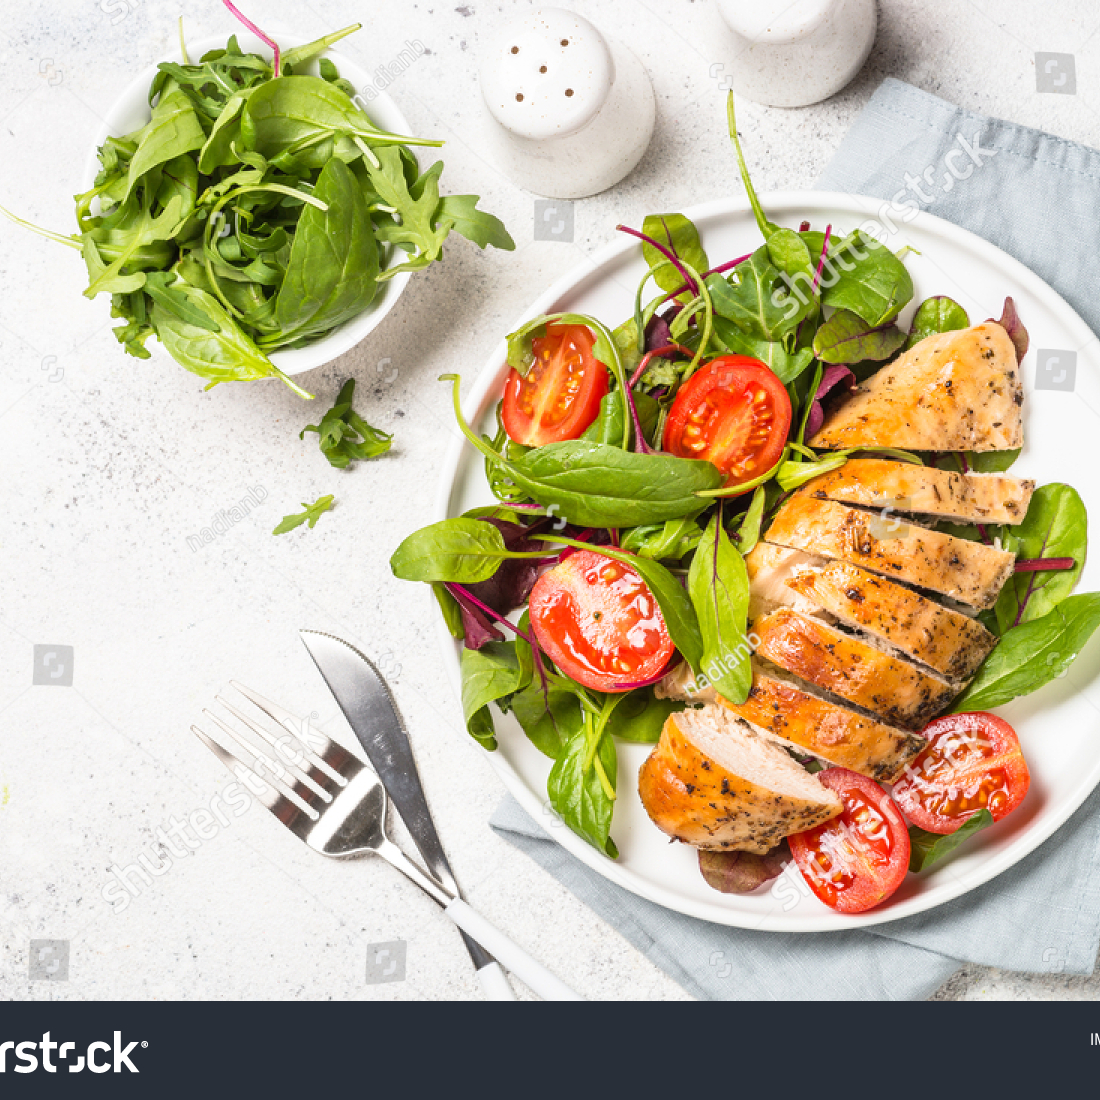

In [52]:
image

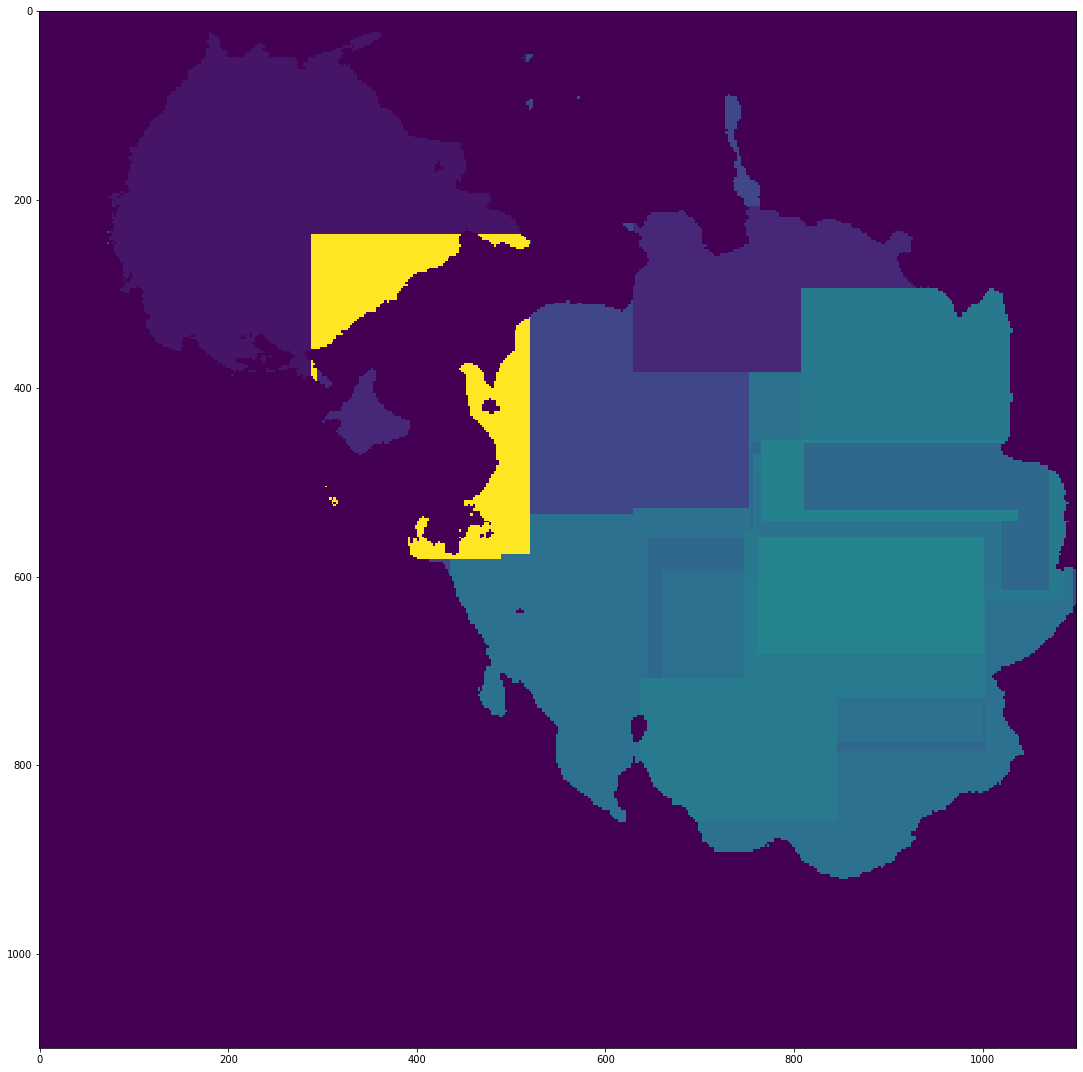

In [53]:
fig, ax = plt.subplots()
ax.imshow(image)
ax.imshow(colories_tensor, interpolation='none', alpha=1)